In [12]:
from astropy.coordinates import SkyCoord, Galactocentric, Galactic
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.optimize import minimize
import pandas as pd

plt.rc('font',family='serif')
plt.rc('text',usetex=True)

In [13]:
mainSeqStars = fits.open("fits_table/new_full_data.fits") #,memmap=True)
MSSdata = mainSeqStars[1].data
newMSSdata = MSSdata.newbyteorder().byteswap()  
df = pd.DataFrame(newMSSdata)
MainSeqQuery = df.query('MainSeqStar == True')
print(len(MainSeqQuery))
print(len(MSSdata))

6158038
12899067


# H-R Diagram

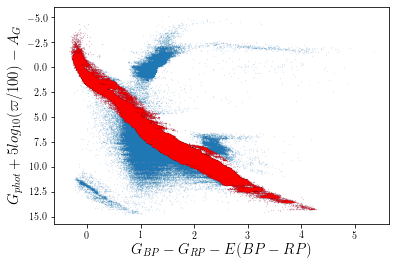

In [423]:
full_x = newMSSdata['bp_rp']-newMSSdata['e_bp_min_rp_val']
full_y = newMSSdata['phot_g_mean_mag']+5*np.log10(newMSSdata['parallax']/100)-newMSSdata['a_g_val']
x = MainSeqQuery['bp_rp']-MainSeqQuery['e_bp_min_rp_val']
y = MainSeqQuery['phot_g_mean_mag']+5*np.log10(MainSeqQuery['parallax']/100)-MainSeqQuery['a_g_val']
plt.plot(full_x,full_y,'.',markersize=0.1)
plt.plot(x,y,'r.',markersize=0.1)
plt.gca().invert_yaxis()

plt.xlabel("$G_{BP}-G_{RP}-E(BP-RP)$",fontsize=15)
plt.ylabel("$G_{phot}+5log_{10}(\\varpi / 100)-A_G$",fontsize=15)
plt.savefig("plot/HR_diagram_python.png")
plt.show()

# select  subgroup and define the correspondent solar velocity:
$G_{BP}-G_{RP}-E(BP-RP)<0.8$

In [14]:
## <0.8
# df = df.query("bp_rp-e_bp_min_rp_val < 0.8")
# u0 = 9.98#*u.km/u.s #km*s-1
# v0 = 20.30#*u.km/u.s #km*s-1
# w0 = 7.51#*u.km/u.s

# 0.8-1.2
# df = df.query("bp_rp-e_bp_min_rp_val >=0.8 & bp_rp-e_bp_min_rp_val <1.2")
# u0 = 10.26#km*s-1
# v0 = 24.20#km*s-1
# w0 = 8.32

# # 1.2-1.6
# df = df.query("bp_rp-e_bp_min_rp_val >=1.2 & bp_rp-e_bp_min_rp_val <1.6")
# u0 = 10.07#*u.km/u.s #km*s-1
# v0 = 25.14#*u.km/u.s #km*s-1
# w0 = 7.92#*u.km/u.s

1.6-2.0
df = df.query("bp_rp-e_bp_min_rp_val >=1.6 & bp_rp-e_bp_min_rp_val <2.0")
u0 = 10.24#km*s-1
v0 = 26.91#km*s-1
w0 = 7.92

# # # ## 2.0-2.4
# df = df.query("bp_rp-e_bp_min_rp_val >=2.0 & bp_rp-e_bp_min_rp_val <2.4")
# u0 = 9.76#km*s-1
# v0 = 23.91#km*s-1
# w0 = 8.00

# ## >2.4
# df = df.query("bp_rp-e_bp_min_rp_val >=2.4")
# u0 = 10.41
# v0 = 22.72#km*s-1
# w0 = 8.00

## $\Delta \mu_l $

In [15]:
data = df.query("b>-20 & b<20")
print(len(data))
l = np.array(data['l'])
b = np.array(data['b'])
ra = np.array(data['ra'])#*u.deg)
dec = np.array(data['dec'])#*u.deg)
pm_ra_cosdec = np.array(data['pmra'])#*u.mas/u.yr)
pm_dec = np.array(data['pmdec'])#*u.mas/u.yr)
radial_velocity = np.array(data['radial_velocity'])#*u.km/u.s)
parallax = np.array(data['parallax'])

# define Skycoord 
skycoords = SkyCoord(ra =ra*u.deg, dec = dec*u.deg,\
                     pm_ra_cosdec=pm_ra_cosdec*u.mas/u.yr, pm_dec=pm_dec*u.mas/u.yr, \
                     radial_velocity=radial_velocity*u.km/u.s, \
                     frame='icrs')

galcen = skycoords.transform_to(Galactic) #convert to Galactic coord

mu_b = galcen.pm_b * 4.74047 / u.mas * u.yr#units of from mas yr-1 to units of km s-1 kpc-1 
mu_l = galcen.pm_l_cosb * 4.74047 / u.mas * u.yr# * u.km/ u.s / u.kpc#convert from units of from mas yr-1 to units of km s-1 kpc-1

distance=np.array(1/data['parallax'])#*u.kpc)

print(len(mu_l))



mu_l_corrected = 1/np.cos(np.radians(b))*(mu_l-parallax*(u0*np.sin(np.radians(l))-v0*np.cos(np.radians(l))))

440648
440648


In [16]:
# sort mu_l into l intevral of 5 degree
q_df_data = {'l':data['l'],
            'mu_l': mu_l_corrected}
q_df = pd.DataFrame(q_df_data,columns=['l','mu_l'])
l_bin = np.arange(0,361,1)
binned = [[] for _ in range(360)]
for j in np.arange(0,360,1):
    qstr = 'l >= %f & l<%f'%(l_bin[j],l_bin[j+1])
    binned[j] = q_df.query(qstr)['mu_l']
    
delta_mu_l_mean = list(map(lambda i: np.mean(i), binned))
xdata = np.arange(0,360,1)
ydata = delta_mu_l_mean

In [131]:

l_bin = np.arange(0,370,10)
binned = [[] for _ in range(36)]
for j in np.arange(0,36,1):
    qstr = 'l >= %f & l<%f'%(l_bin[j],l_bin[j+1])
    binned[j] = q_df.query(qstr)['mu_l']
    
delta_mu_l_mean = list(map(lambda i: np.mean(i), binned))
xdata = np.arange(0,360,10)
ydata = delta_mu_l_mean

A,B,C for 0.8-1.2 stellar population:  [ 14.93162579 -12.87241613  -3.02229248]


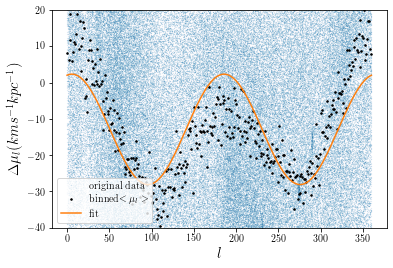

In [17]:
# least square fitting
def mu_l_func(l,A,B,C):
    return A*np.cos(np.radians(2*l))-C*np.sin(np.radians(2*l))+B

popt,pcov = curve_fit(mu_l_func,xdata,ydata)
# popt,pcov = curve_fit(mu_l_func,xdata[::36],ydata[::36])
print("A,B,C for 0.8-1.2 stellar population: ", popt)

xfit = np.linspace(0,360,361)
plt.plot(data['l'],mu_l_corrected,'.',label = "original data",markersize=0.1)
plt.plot(xdata,ydata,'k.',markersize=3,label="binned$<\mu_l>$")
plt.plot(xfit,mu_l_func(xfit,*popt),'-',label="fit")

plt.ylim(-40,20)

plt.legend()
plt.xlabel("$l$",fontsize=15)
plt.ylabel('$\Delta \mu _l(kms^{-1}kpc^{-1})$',fontsize=15)
# plt.title("$G_{BP}-G_{RP}-E(BP-RP)<0.8$")
# plt.title("$0.8\\leq G_{BP}-G_{RP}-E(BP-RP)<1.2$",fontsize=15)
# plt.title("$2.0\\leq G_{BP}-G_{RP}-E(BP-RP)<2.4$",fontsize=15)
# plt.title("$G_{BP}-G_{RP}-E(BP-RP)\\geq 2.4 $",fontsize=15)
# plt.savefig('plot/12mu_l_fit_bin1.png')
plt.show()

## $\Delta \mu_b$

In [136]:
data = df.query("(b>40 & b<50)|(b>-50 & b<-40)")
# data = df.query("(b<-20 & b<20)")#& bp_rp-e_bp_min_rp_val <1.2")#"& bp_g-g_rp-e_bp_min_rp_val < 1.2" )

In [137]:
l = np.array(data['l'])
b = np.array(data['b'])
ra=np.array(data['ra'])#*u.deg)
dec=np.array(data['dec'])#*u.deg)
pm_ra_cosdec=np.array(data['pmra'])#*u.mas/u.yr)
pm_dec=np.array(data['pmdec'])#*u.mas/u.yr)
radial_velocity=np.array(data['radial_velocity'])#*u.km/u.s)
parallax = np.array(data['parallax'])
# define Skycoord 
skycoords = SkyCoord(ra =ra*u.deg, dec = dec*u.deg,\
                     pm_ra_cosdec=pm_ra_cosdec*u.mas/u.yr, pm_dec=pm_dec*u.mas/u.yr, \
                     radial_velocity=radial_velocity*u.km/u.s, \
                     frame='icrs')

galcen = skycoords.transform_to(Galactic) #convert to Galactic coord
mu_b = galcen.pm_b * 4.74047 / u.mas * u.yr 

print(len(l))


mu_b_corrected = -1*(mu_b-parallax*((u0*np.cos(np.radians(l))+v0*np.sin(np.radians(l)))*np.sin(np.radians(b))\
                     -w0*np.cos(np.radians(b))))/(np.sin(np.radians(b))*np.cos(np.radians(b)))

q_df_data = {'l':data['l'],
            'mu_b':mu_b_corrected}
q_df = pd.DataFrame(q_df_data,columns=['l','mu_b'])

98113


In [143]:
# # sort mu_b into binned l interval
# l_bin = np.arange(0,396,36)
# binned = [[] for _ in range(10)]
# for j in np.arange(0,10,1):
#     qstr = 'l >= %f & l<%f'%(l_bin[j],l_bin[j+1])
#     binned[j] = q_df.query(qstr)['mu_b']
    
# mu_b_mean = list(map(lambda i: np.mean(i), binned))
# xdata2 = np.arange(0,360,36)
# ydata2 = mu_b_mean

# 1 degree bin
l_bin = np.arange(0,361,1)
binned = [[] for _ in range(360)]
for j in np.arange(0,360,1):
    qstr = 'l >= %f & l<%f'%(l_bin[j],l_bin[j+1])
    binned[j] = q_df.query(qstr)['mu_b']
    
mu_b_mean = list(map(lambda i: np.mean(i), binned))
xdata2 = np.arange(0,360,1)
ydata2 = mu_b_mean

A,C,K for <0.8 stellar population:  [ 9.2944052   1.80315866 -7.55069058]


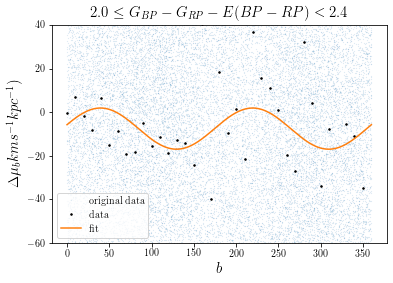

In [144]:
def mu_b_func(l,A,C,K):
    return A*np.sin(np.radians(2*l))+C*np.cos(np.radians(2*l))+K

popt2,pcov2 = curve_fit(mu_b_func,xdata2[::10],ydata2[::10])
print("A,C,K for <0.8 stellar population: ", popt2)

xfit = np.linspace(0,360,361)

plt.plot(data['l'],mu_b_corrected,'.',label = "original data",markersize=0.1)
plt.plot(xdata2[::10],ydata2[::10],'k.',markersize=3,label="data")
plt.plot(xfit,mu_b_func(xfit,*popt2),'-',label="fit")
plt.legend()
plt.ylim(-60,40)
# plt.title("$G_{BP}-G_{RP}-E(BP-RP)<0.8$")
# plt.title("$0.8\\leq G_{BP}-G_{RP}-E(BP-RP)<1.2$",fontsize=15)
plt.title("$2.0\\leq G_{BP}-G_{RP}-E(BP-RP)<2.4$",fontsize=15)
plt.xlabel("$b$",fontsize=15)
plt.ylabel('$\Delta \mu _b kms^{-1}kpc^{-1})$',fontsize=15)
plt.savefig("plot/24_mu_b_fitbin1_by_10.png")
plt.show()

## $v_{los}$ as a function of $l$

In [94]:
sample_vlos = df.dropna(subset=['radial_velocity'])
data = sample_vlos.query("b>-20 & b <20 ")

In [95]:

l = np.array(data['l'])
b = np.array(data['b'])
ra=np.array(data['ra'])#*u.deg)
dec=np.array(data['dec'])#*u.deg)
pm_ra_cosdec=np.array(data['pmra'])#*u.mas/u.yr)
pm_dec=np.array(data['pmdec'])#*u.mas/u.yr)
radial_velocity=np.array(data['radial_velocity'])#*u.km/u.s)
parallax = np.array(data['parallax'])

# define Skycoord 
skycoords = SkyCoord(ra =ra*u.deg, dec = dec*u.deg,\
                     pm_ra_cosdec=pm_ra_cosdec*u.mas/u.yr, pm_dec=pm_dec*u.mas/u.yr, \
                     radial_velocity=radial_velocity*u.km/u.s, \
                     frame='icrs')

radial_v = skycoords.galactic.radial_velocity /u.km*u.s#* 4.74047 / u.mas * u.yr * u.km/ u.s / u.kpc
print(len(radial_v))


vlos_over_d = parallax*(radial_v\
                                +u0*np.cos(np.radians(l))\
                                +v0*np.sin(np.radians(l)))

q_df_data = {'l':data['l'],
            'vlos_over_d':vlos_over_d}
q_df = pd.DataFrame(q_df_data,columns=['l','vlos_over_d'])

7823


In [373]:
l_bin = np.arange(0,361,1)
binned = [[] for _ in range(360)]
for j in np.arange(0,360,1):
    qstr = 'l >= %f & l<%f'%(l_bin[j],l_bin[j+1])
    binned[j] = q_df.query(qstr)['vlos_over_d']
    
vlos_mean_overD = list(map(lambda i: np.mean(i), binned))
xdata3 = np.arange(0,360,1)
ydata3 = vlos_mean_overD

sample size:  43436
A,C,K for <0.8 stellar population:  [16.99303124 -1.08670969  1.93008182]


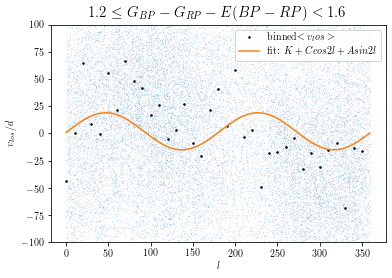

In [385]:
def vlos_corrected(l,A,C,K):
    return A*np.sin(np.radians(2*l))+C*np.cos(np.radians(2*l))+K

popt3,pcov3 = curve_fit(vlos_corrected,xdata3,vlos_mean_overD)

print()"$1.2\\leq G_{BP}-G_{RP}-E(BP-RP)<1.6$
print("sample size: ", len(l))
print("A,C,K for <0.8 stellar population: ", popt3)

xdata = np.arange(0,360,1)

plt.plot(data['l'],vlos_over_d,'.',markersize=0.1)
plt.plot(xdata3[::10], ydata3[::10],'k.',markersize=3,label="binned$<v_los>$")
plt.plot(xdata3,vlos_corrected(xdata3,*popt3),'-',label="fit: $K+Ccos2l+Asin2l$")
plt.xlabel("$l$")
plt.ylabel("$v_{los}/d$")
plt.ylim(-100,100)
plt.legend()
# plt.title("$G_{BP}-G_{RP}-E(BP-RP)<0.8$")
# plt.title("$0.8\\leq G_{BP}-G_{RP}-E(BP-RP)<1.2$",fontsize=15)
plt.title("$1.2\\leq G_{BP}-G_{RP}-E(BP-RP)<1.6$",fontsize=15)
plt.savefig("plot/16_vlos_fit.png")

In [380]:
print(xdata3[::36])

[  0  36  72 108 144 180 216 252 288 324]
